In [25]:
using Plots, DataFrames, CSV, GLM
using Optim, Distributions, Random
using LinearAlgebra, StatsFuns
using LaTeXTabulars

In [26]:
# Load data
df = DataFrame(CSV.File("../data/ps2_ex3.csv"));
rename!(df, :milage => :mileage);

# Number of observations
T = size(df)[1];

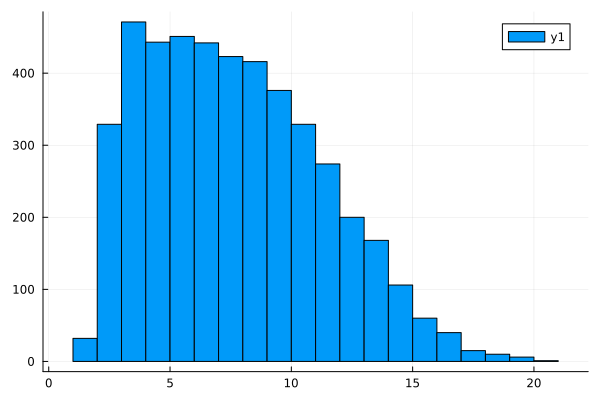

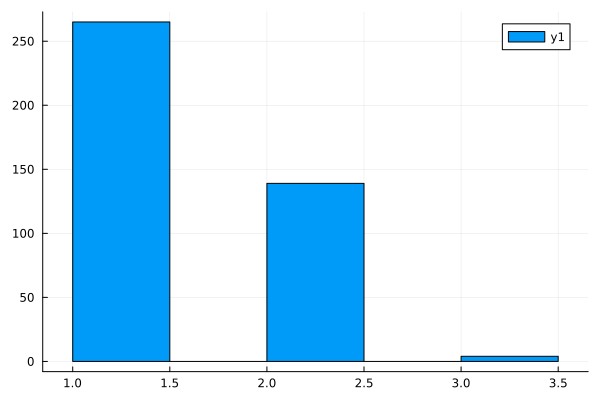

In [27]:
# Infer replacement (d = 1)
df[!,:d] .= 0;
for t = 2:T
    df[t,:d] = (df[t,:mileage] < df[t-1,:mileage]);
end

# Discretize groups into K bins of size = max(mileage) / K
K = 20
df[!,:x] = Integer.(fld.(df[!,:mileage],maximum(df.mileage)/K) .+ 1);

# Histogram of counts conditional on replacement
display(histogram(df[df.d .=== 0,:].x))
display(histogram(df[df.d .=== 1,:].x))

In [88]:
### Construct transition matrix

# Create columns representing indicators for next period bin, y
col_names = []
for k = 1:K
    df[!, "y_$k"] .= 0
    push!(col_names,"y_$k")
end

for t = 1:T-1
    y = df[t+1,:x]
    df[t,"y_$y"] = 1
end

# Calculate transition matrices, Π_d
Π₁ = zeros(20,20)
Π₀ = zeros(20,20)
for x = 1:20
    for y = 1:20
        Π₁[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 1), "y_$y"])
        Π₀[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 0), "y_$y"])
    end
end
replace!(Π₁, NaN .=> 0.0)
replace!(Π₀, NaN .=> 0.0)

display(Π₁)
display(Π₀)

20×20 Matrix{Float64}:
 0.116981  0.735849  0.143396  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.359712  0.604317     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.5          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0 

20×20 Matrix{Float64}:
 0.03125     0.84375     0.125       …  0.0        0.0       0.0  0.0
 0.0         0.173252    0.693009       0.0        0.0       0.0  0.0
 0.0         0.0         0.242038       0.0        0.0       0.0  0.0
 0.00225734  0.0         0.0            0.0        0.0       0.0  0.0
 0.00443459  0.00886918  0.0            0.0        0.0       0.0  0.0
 0.00904977  0.00904977  0.0         …  0.0        0.0       0.0  0.0
 0.0283688   0.0212766   0.00236407     0.0        0.0       0.0  0.0
 0.0408654   0.0120192   0.0            0.0        0.0       0.0  0.0
 0.0718085   0.0505319   0.00265957     0.0        0.0       0.0  0.0
 0.112462    0.0395137   0.0            0.0        0.0       0.0  0.0
 0.149635    0.0510949   0.0         …  0.0        0.0       0.0  0.0
 0.14        0.09        0.005          0.0        0.0       0.0  0.0
 0.14881     0.136905    0.00595238     0.0        0.0       0.0  0.0
 0.264151    0.113208    0.0            0.0        0.0       0.0  0

In [89]:
function nfxp()

end

function likelihood()

end

likelihood (generic function with 1 method)

In [ ]:
# Solve model
β = 0.999